##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

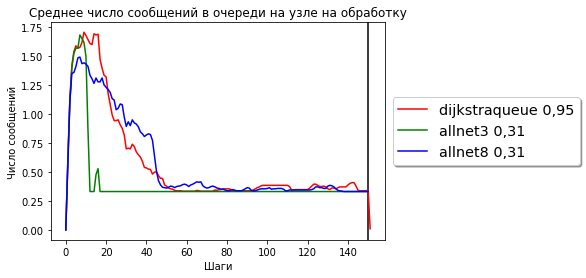

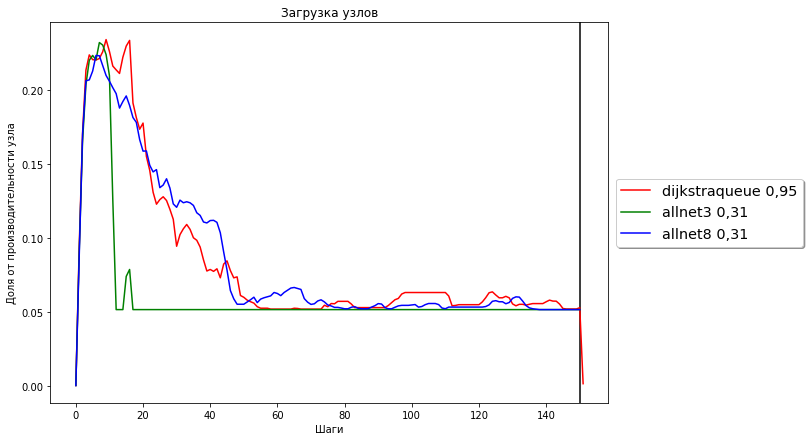

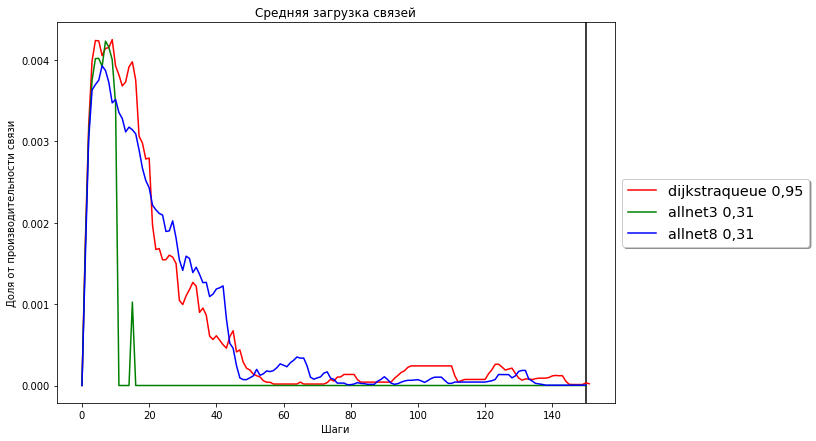

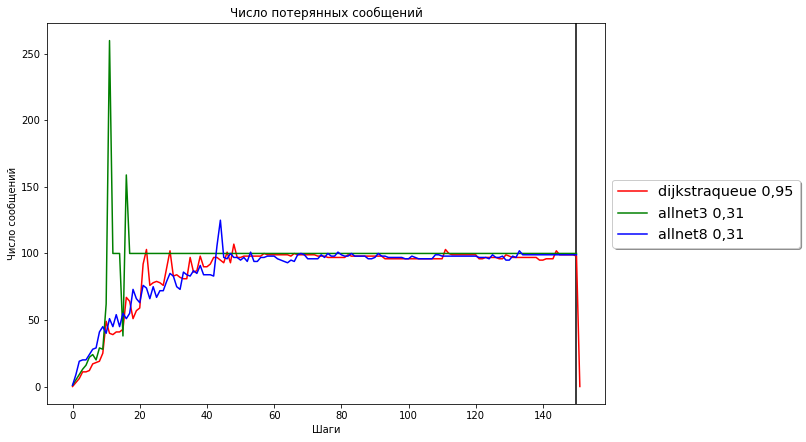

Доставлено 1858 Потеряно 87.6142% -dijkstraqueue 0,95
Доставлено 615 Потеряно 95.9003% -allnet3 0,31
Доставлено 1848 Потеряно 87.6808% -allnet8 0,31


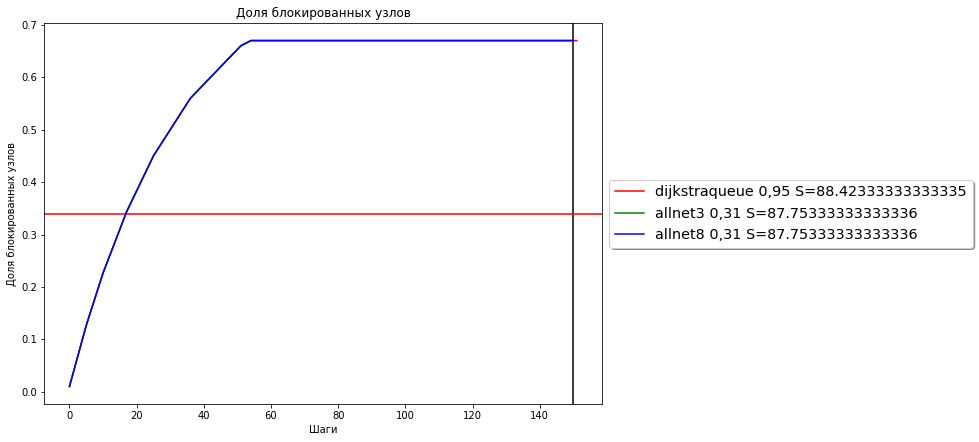

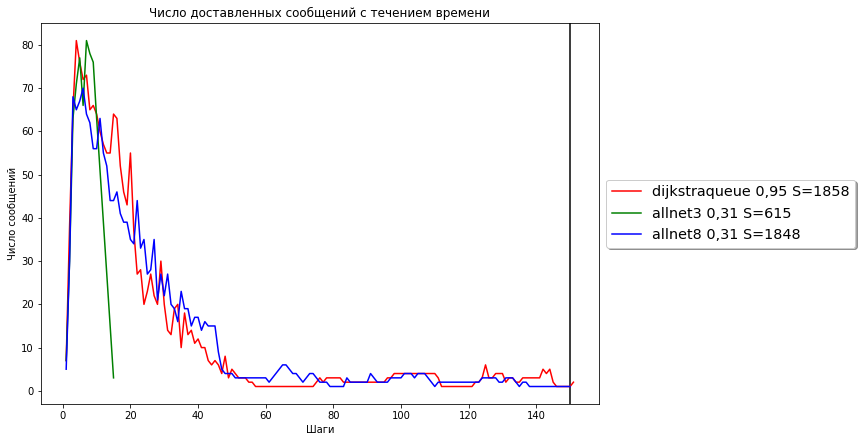

In [2]:
quantity = 100;
log_tags = [
{"tag":  "e8f7b484-2c02-4cd4-8ad2-2ca730e014a7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "eafa7e81-f130-46a0-91d9-796cc36421e6", "label": "allnet3 0,31", "color": "green"},
{"tag":  "215df08a-37e2-42fa-85ce-938026aff87f", "label": "allnet8 0,31", "color": "blue"},
]                           
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

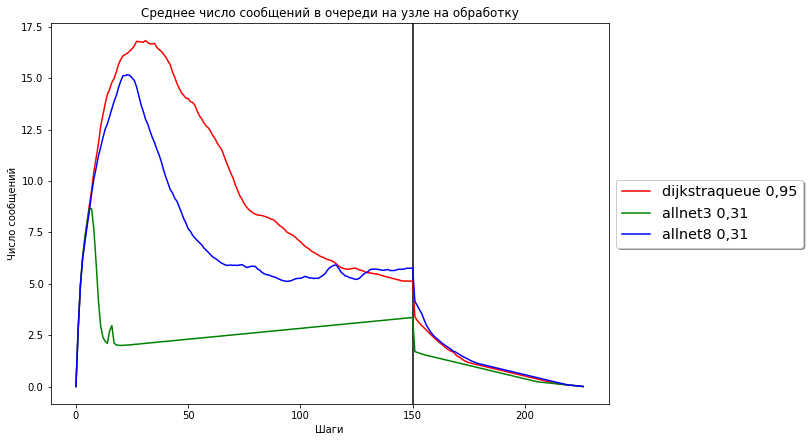

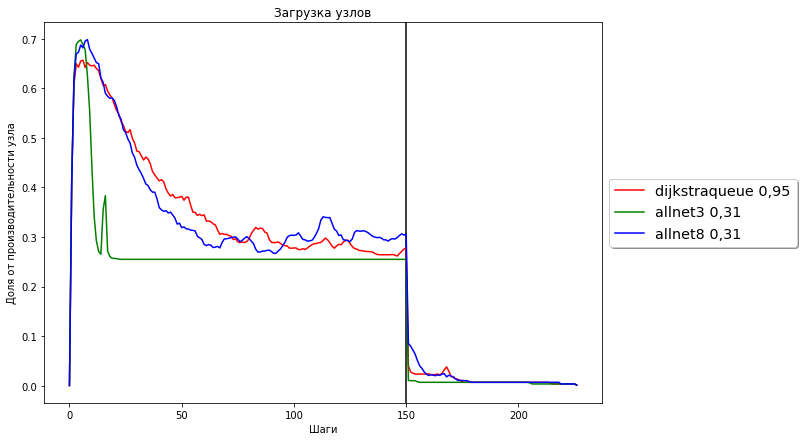

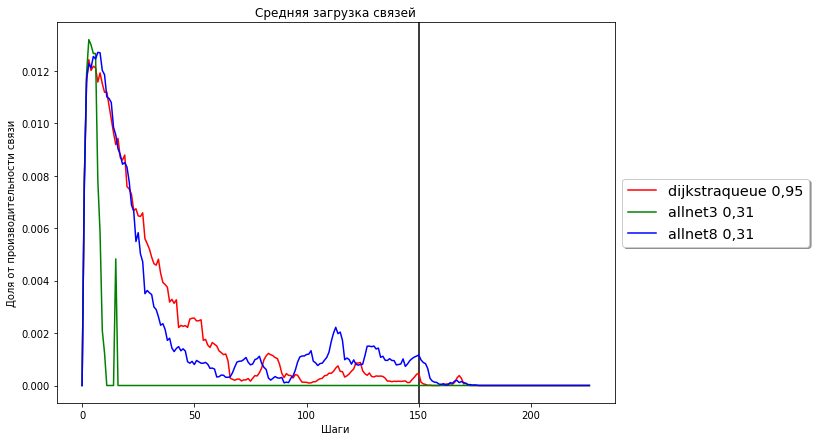

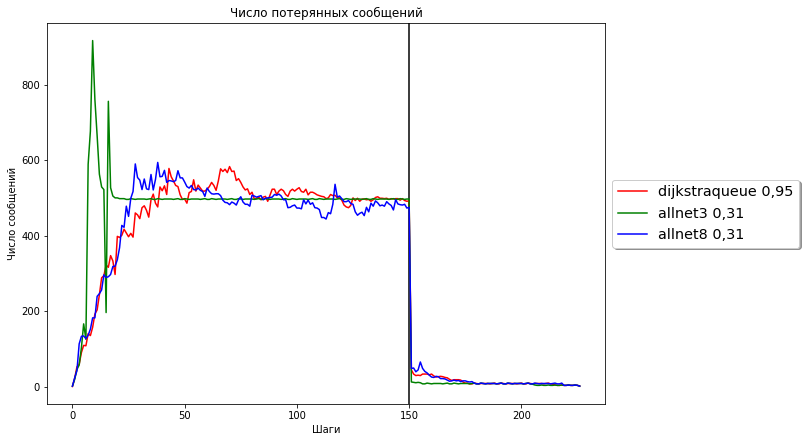

Доставлено 4259 Потеряно 94.3214% -dijkstraqueue 0,95
Доставлено 1176 Потеряно 98.4320% -allnet3 0,31
Доставлено 5004 Потеряно 93.3281% -allnet8 0,31


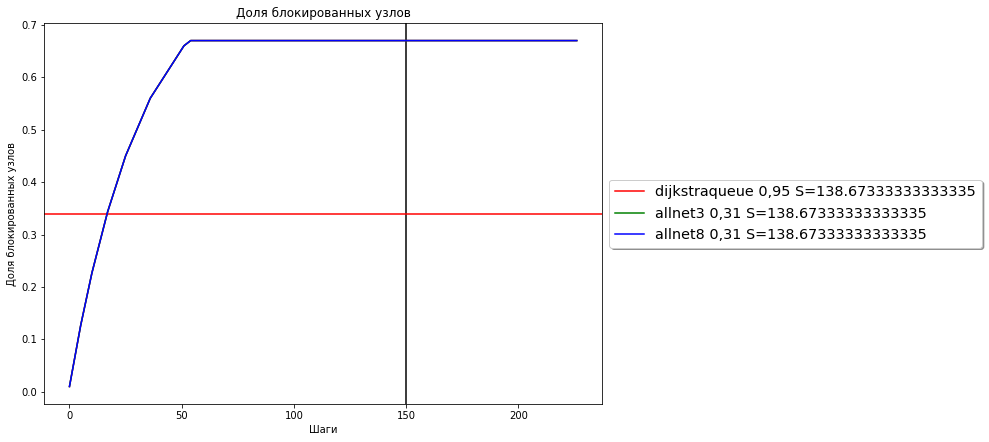

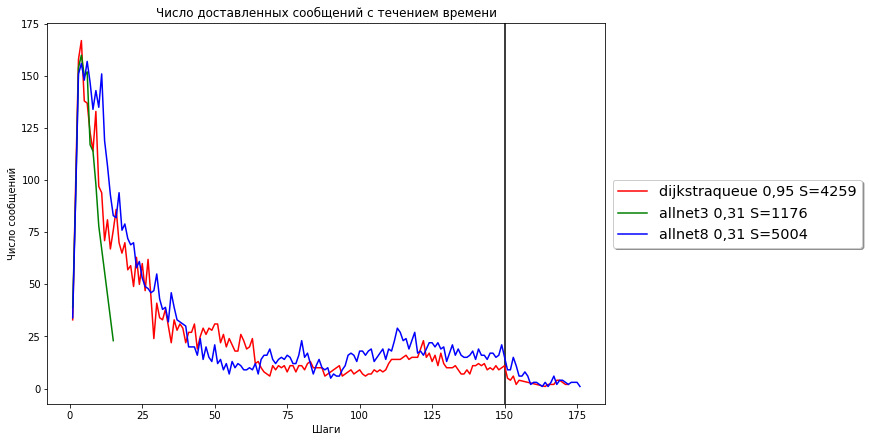

In [3]:
quantity = 500;
log_tags = [
{"tag":  "5c8b61c4-1144-4b82-9e9a-fd8ee148eaf9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f7db1e17-278a-4a5f-99d4-e8ad9e8e9b81", "label": "allnet3 0,31", "color": "green"},
{"tag":  "34546ed4-831d-4b5b-9ff6-3fadbc753ada", "label": "allnet8 0,31", "color": "blue"},

] 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

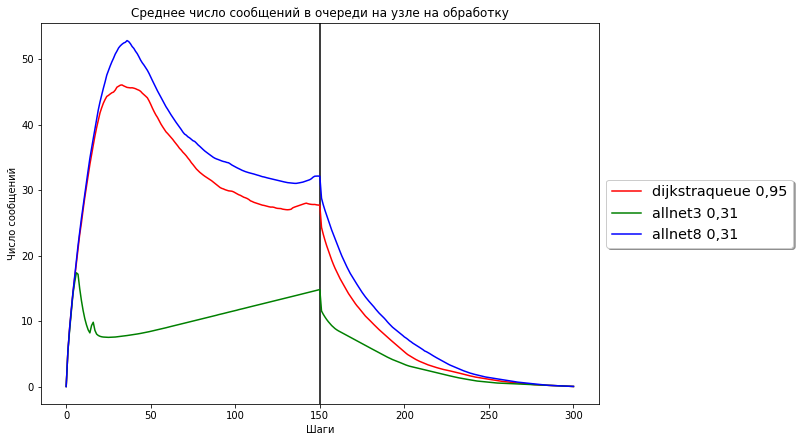

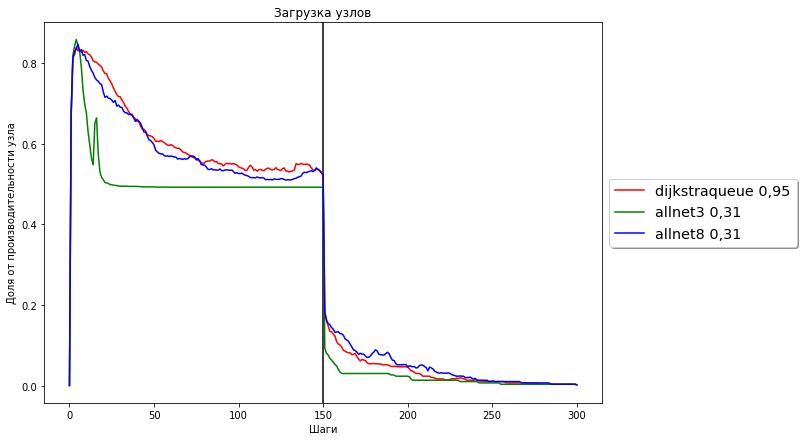

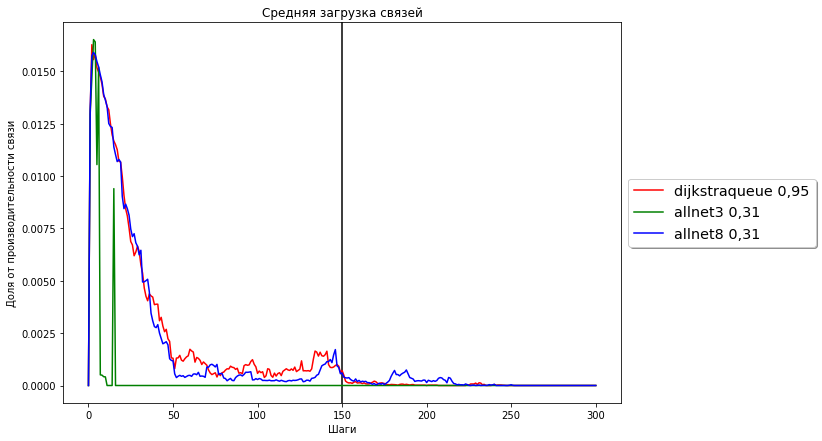

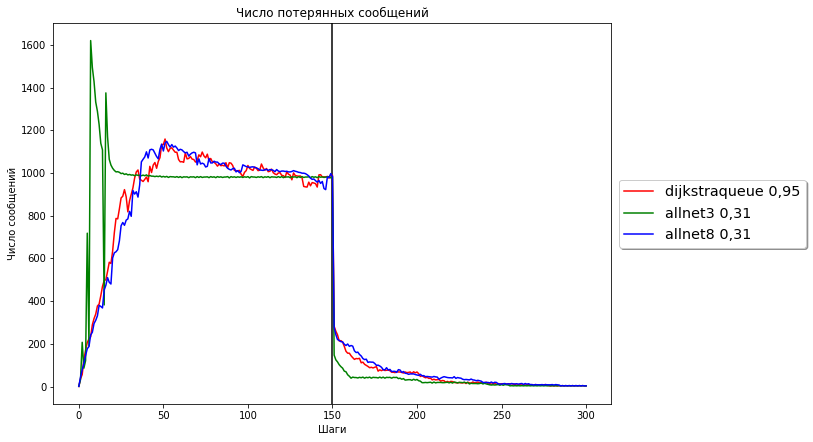

Доставлено 5098 Потеряно 96.6014% -dijkstraqueue 0,95
Доставлено 679 Потеряно 99.5473% -allnet3 0,31
Доставлено 4578 Потеряно 96.9480% -allnet8 0,31


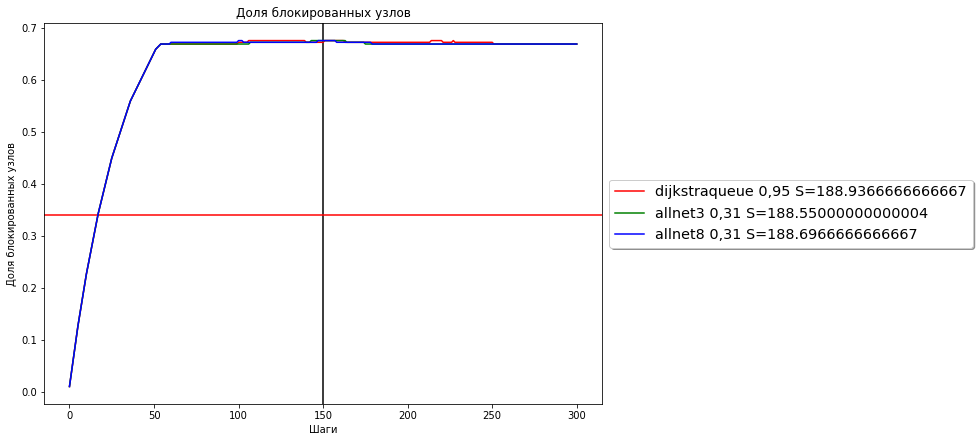

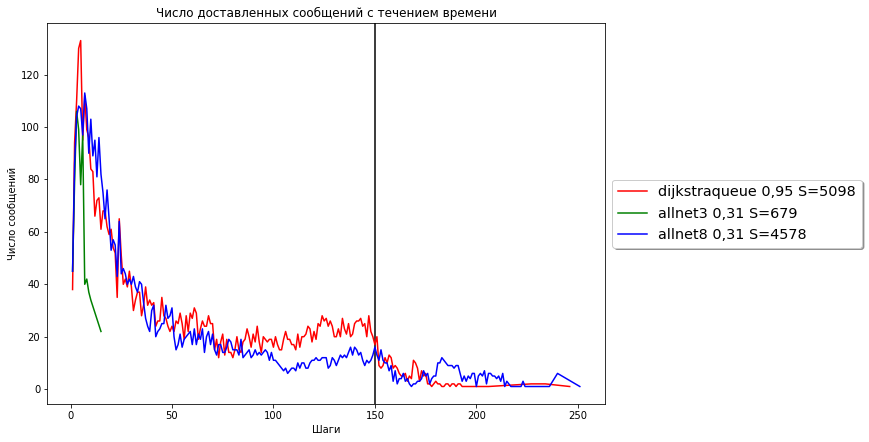

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "d51997b3-f228-4fa6-93a9-b8f7e6c72f41", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b5a42cfb-f51f-46e7-8223-1e71e44b1904", "label": "allnet3 0,31", "color": "green"},
{"tag":  "9566a5bc-10ef-4d64-8c81-469992694483", "label": "allnet8 0,31", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

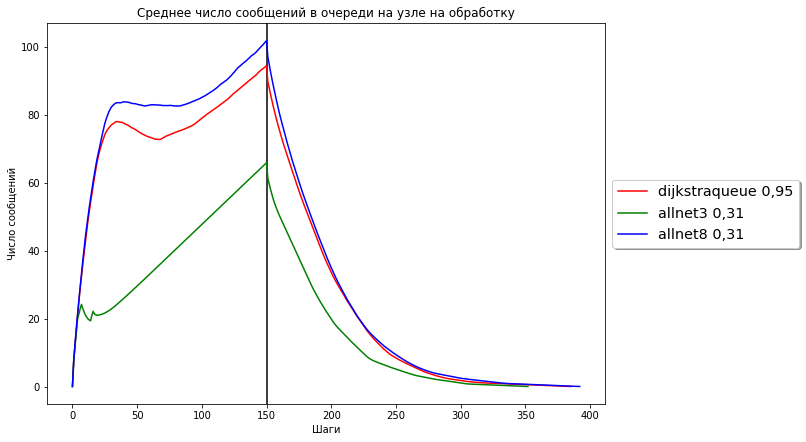

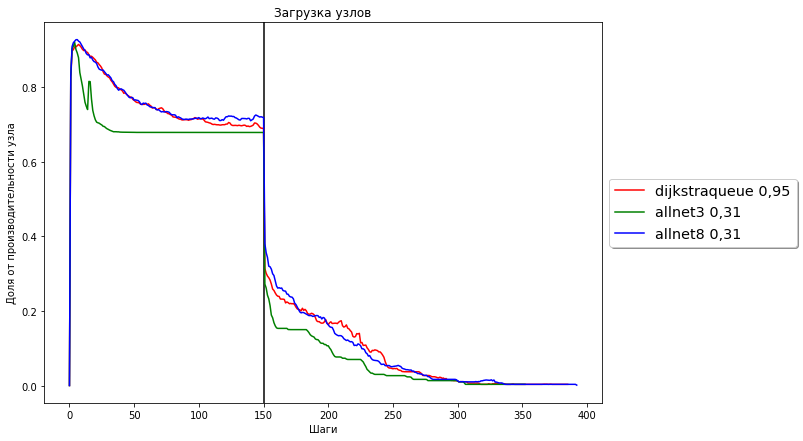

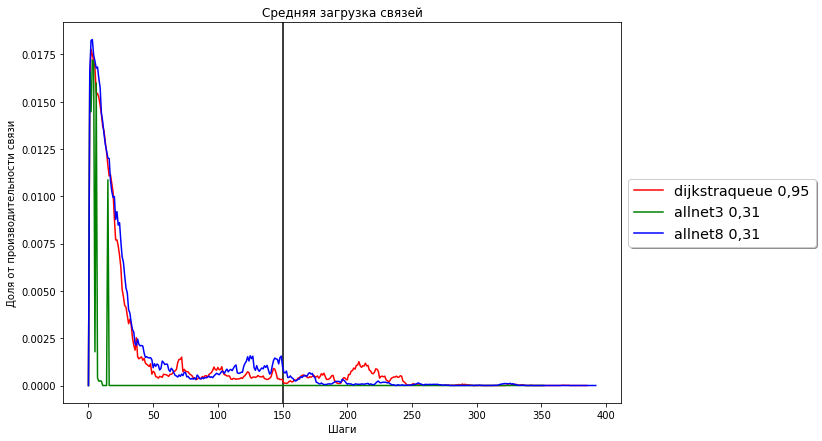

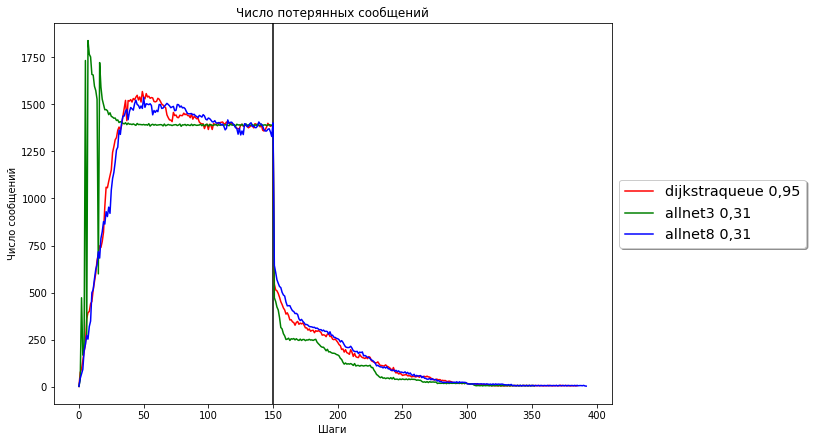

Доставлено 4874 Потеряно 97.8338% -dijkstraqueue 0,95
Доставлено 495 Потеряно 99.7800% -allnet3 0,31
Доставлено 4408 Потеряно 98.0409% -allnet8 0,31


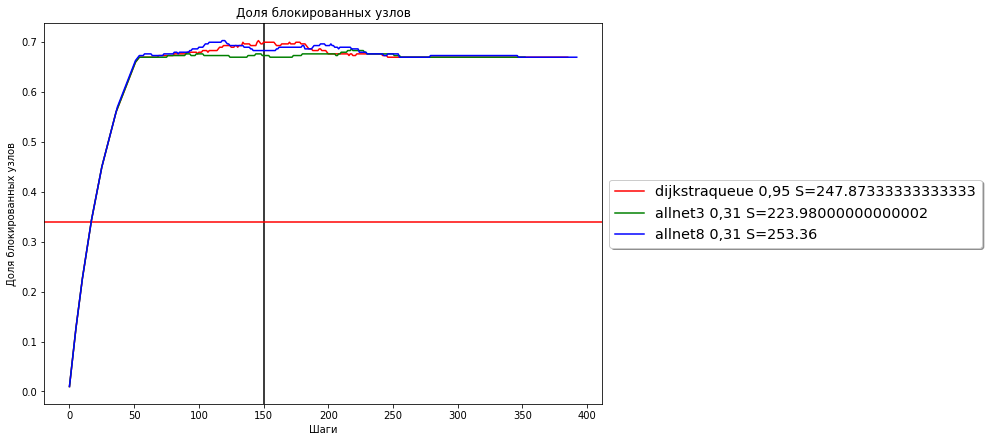

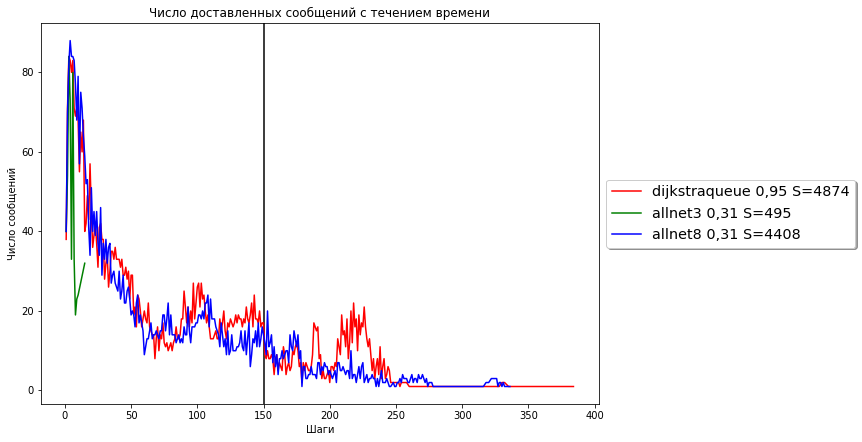

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "ebfae23a-5969-4183-8c80-e25d0dc849d4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e8c8505e-d2e5-481e-a6f3-dd094451c702", "label": "allnet3 0,31", "color": "green"},
{"tag":  "5abe6418-6e05-43c3-82b4-257df9136880", "label": "allnet8 0,31", "color": "blue"},

] 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 4163 Потеряно 90.7491% -dijkstraqueue 0,95
Доставлено 1217 Потеряно 97.2956% -allnet3 0,31
Доставлено 3837 Потеряно 91.4735% -allnet8 0,31


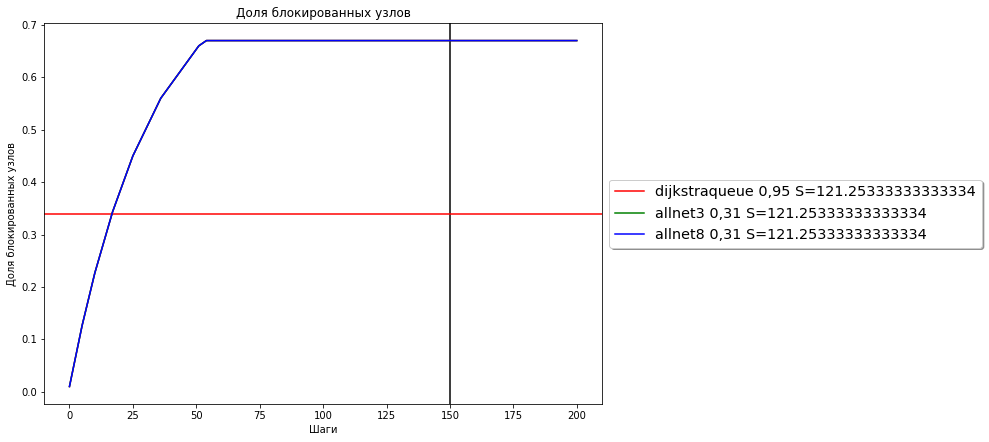

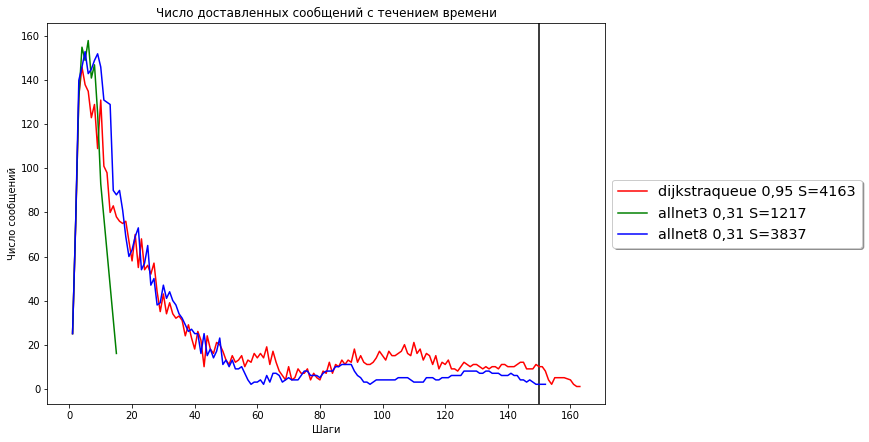

Доставлено 4441 Потеряно 95.7705% -dijkstraqueue 0,95
Доставлено 932 Потеряно 99.1124% -allnet3 0,31
Доставлено 4795 Потеряно 95.4334% -allnet8 0,31


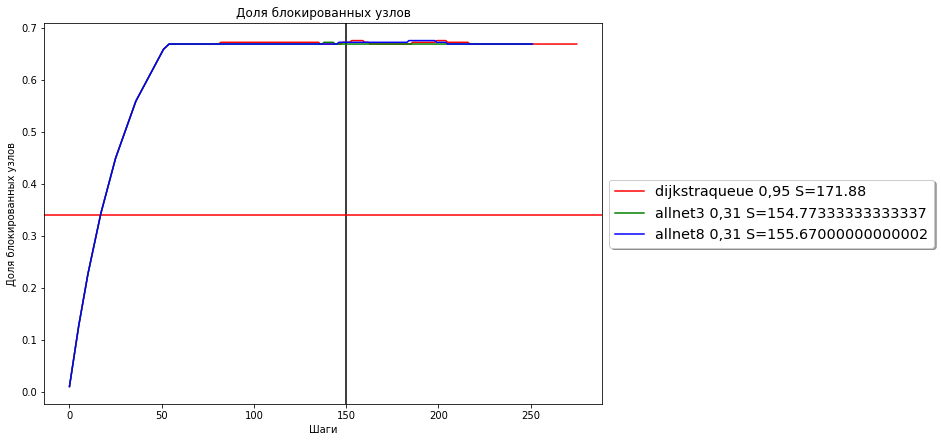

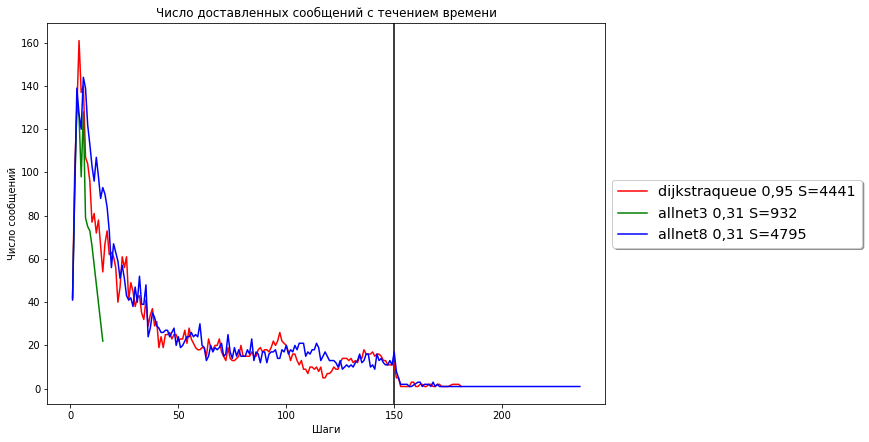

Доставлено 5402 Потеряно 95.9985% -dijkstraqueue 0,95
Доставлено 897 Потеряно 99.3356% -allnet3 0,31
Доставлено 5001 Потеряно 96.2956% -allnet8 0,31


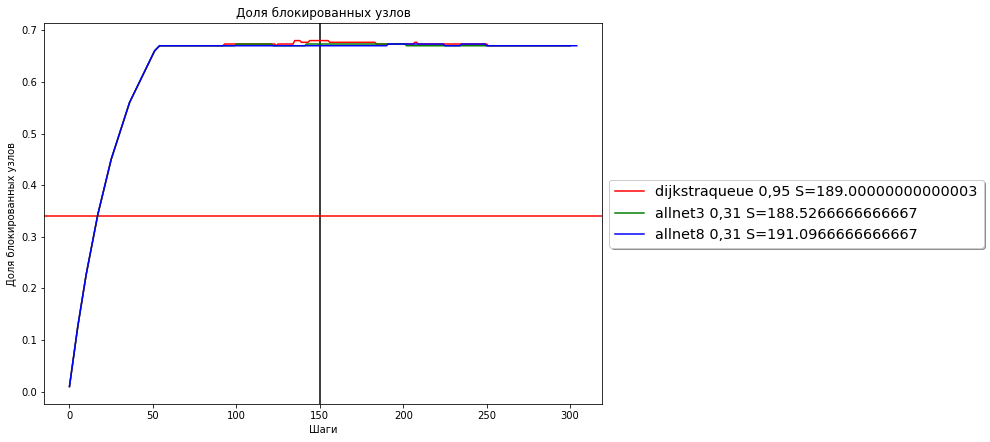

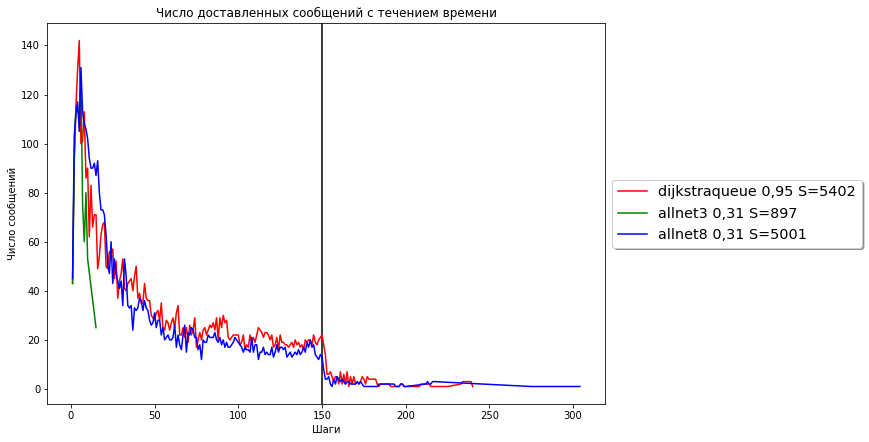

Доставлено 6153 Потеряно 96.8446% -dijkstraqueue 0,95
Доставлено 608 Потеряно 99.6882% -allnet3 0,31
Доставлено 5275 Потеряно 97.2949% -allnet8 0,31


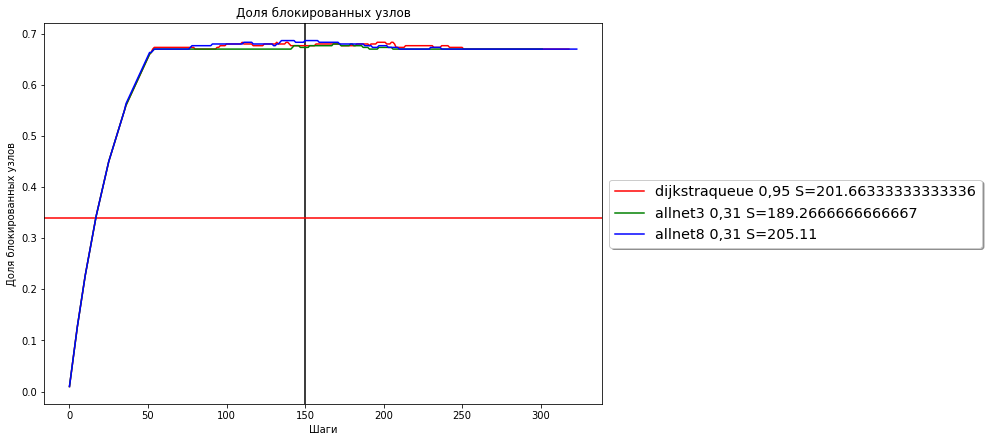

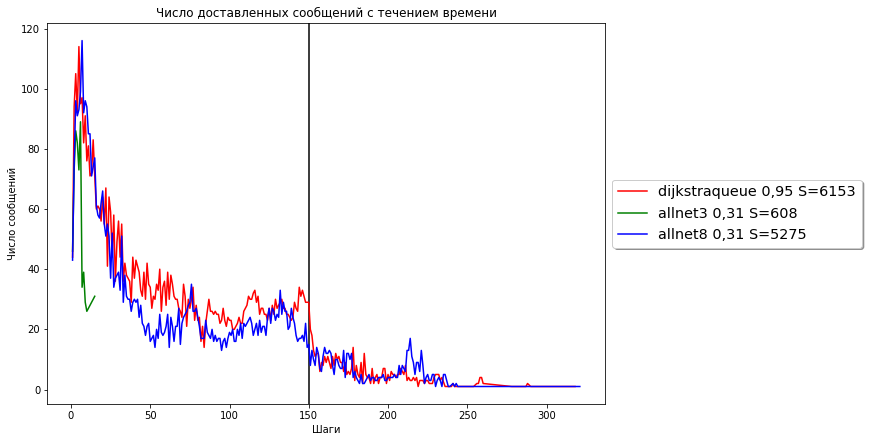

In [6]:
quantity = 300;
log_tags = [
{"tag":  "dfb40df7-fa68-419b-88d4-60b1bf0ba790", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e28ac59e-eb8f-41f4-9d15-83e1689d1883", "label": "allnet3 0,31", "color": "green"},
{"tag":  "6f07cb1a-c2ce-4289-b6ef-c13173aab148", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "becf6456-633a-4f0b-a7eb-36223dcf2d64", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "aa1af2e1-439c-4bd2-a936-3f8b29b82b9e", "label": "allnet3 0,31", "color": "green"},
{"tag":  "07339c49-3d60-4ad2-8f4c-78ba31c0f0ab", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "d71c4fba-6377-43bb-8530-e1b80f2d943e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d29d0647-35ac-4e08-80f3-1daa523771f5", "label": "allnet3 0,31", "color": "green"},
{"tag":  "16694b29-cf08-45e4-b16b-d3febd3037a6", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "2784efc2-5e01-4ee3-bdae-db1be130452d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "76245758-f8c2-45b2-9135-b505c86ec795", "label": "allnet3 0,31", "color": "green"},
{"tag":  "68195c07-2dca-40c3-b65d-7b21b0062190", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

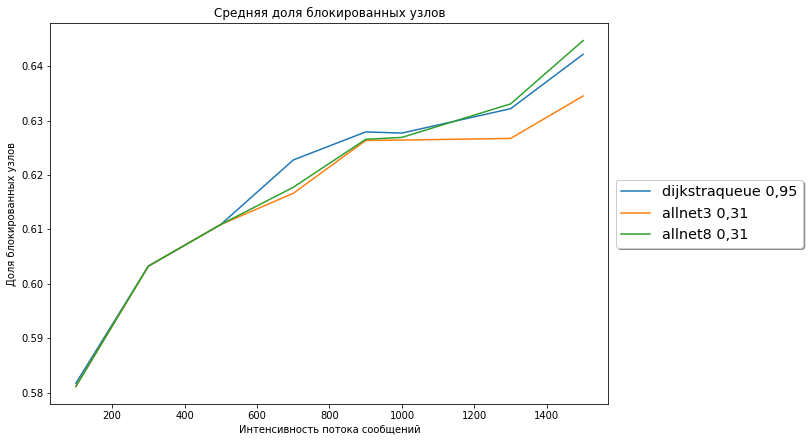

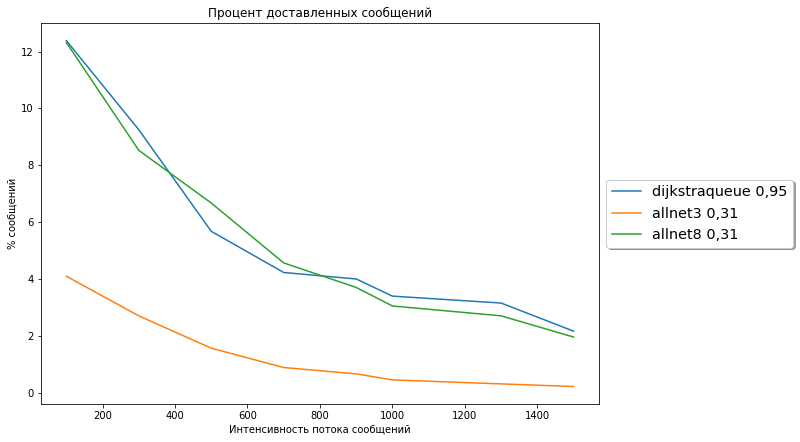

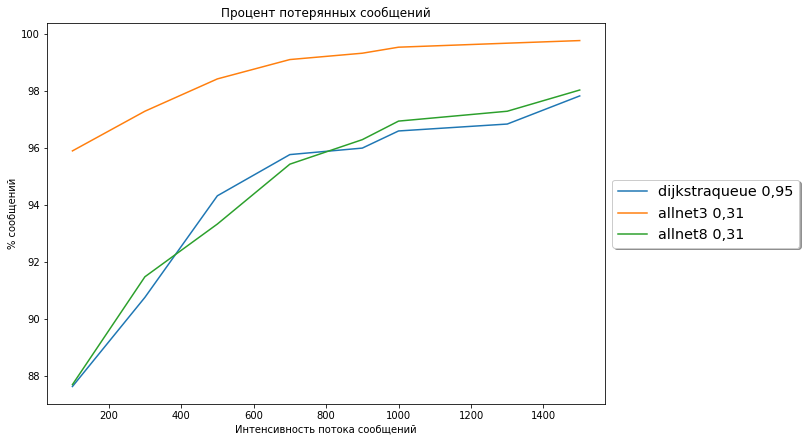

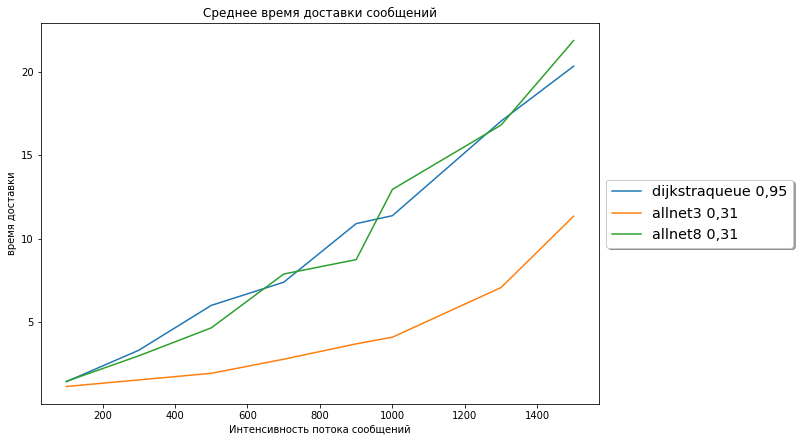

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.618571
allnet3 0,31          0.615735
allnet8 0,31          0.618027

dijkstraqueue 0,95    94.466688
allnet3 0,31          98.636425
allnet8 0,31          94.561900

dijkstraqueue 0,95    9.722094
allnet3 0,31          4.183513
allnet8 0,31          9.665049
